![banner](https://user-images.githubusercontent.com/5395649/46774810-22395980-ccb9-11e8-8f1a-535769d657ec.png)

We'll first start by installing some libraries that are not installed in the notebook session environment. 

In [2]:
%%bash 

pip install -r requirements-tmp.txt > pip_logs

# Short Introduction to Audio Data 

In this notebook, we will provide a simple introduction to audio data. If you are already familiar with 
Fast Fourier Transforms and Mel-frequency cepstral coefficients (MFCCs), feel free to skip this notebook. 

In [3]:
import matplotlib.pyplot as plt 
from scipy import signal 
from scipy.io import wavfile 
import os 
import IPython.display as ipd
import math as mt 
import librosa 
from librosa.display import waveplot

%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

Populating the interactive namespace from numpy and matplotlib


## Getting the Dataset from Object Storage 

First step is to get the dataset. For the purpose of this demo we hosted a copy of the dataset on OCI Object Storage. The dataset is publicly available as a pre-authenticated request. 

We'll pull a the tarball from object storage that contains a collection of .wave files. 

In [10]:
%%bash 

data_dir="/home/datascience/block_storage/speech-commands/data/"
cd ${data_dir} 

wget -nv https://objectstorage.us-ashburn-1.oraclecloud.com/p/NtbWWtsgTBJezjl88N5XmssCO1gP-zhsObtMzlEMtdQ/n/bigdatadatasciencelarge/b/hosted-ds-datasets/o/speech_commands_v0.01.tar.gz

gunzip speech_commands_v0.01.tar.gz && tar -xvf speech_commands_v0.01.tar 

./
./eight/
./eight/1b88bf70_nohash_0.wav
./eight/798f702a_nohash_2.wav
./eight/b12bef84_nohash_1.wav
./eight/05b2db80_nohash_1.wav
./eight/750e3e75_nohash_0.wav
./eight/3852fca2_nohash_0.wav
./eight/5ac04a92_nohash_0.wav
./eight/778a4a01_nohash_0.wav
./eight/61e50f62_nohash_0.wav
./eight/17c94b23_nohash_0.wav
./eight/037c445a_nohash_1.wav
./eight/11321027_nohash_0.wav
./eight/b97c9f77_nohash_1.wav
./eight/10467b06_nohash_1.wav
./eight/baf01c1f_nohash_0.wav
./eight/48bdc11c_nohash_0.wav
./eight/cb2929ce_nohash_4.wav
./eight/a6285644_nohash_2.wav
./eight/01b4757a_nohash_0.wav
./eight/ea1f888c_nohash_0.wav
./eight/a6285644_nohash_1.wav
./eight/88120683_nohash_0.wav
./eight/f44f440f_nohash_2.wav
./eight/1ecfb537_nohash_2.wav
./eight/7ff4fc72_nohash_0.wav
./eight/57b68383_nohash_2.wav
./eight/f0edc767_nohash_0.wav
./eight/50f55535_nohash_0.wav
./eight/cd7f8c1b_nohash_2.wav
./eight/98582fee_nohash_1.wav
./eight/b8872c20_nohash_0.wav
./eight/4a4e28f1_nohash_3.wav
./eight/9587481f_nohash_0.wa

2020-02-22 00:23:27 URL:https://objectstorage.us-ashburn-1.oraclecloud.com/p/NtbWWtsgTBJezjl88N5XmssCO1gP-zhsObtMzlEMtdQ/n/bigdatadatasciencelarge/b/hosted-ds-datasets/o/speech_commands_v0.01.tar.gz [1489096277/1489096277] -> "speech_commands_v0.01.tar.gz" [1]


# Play a .wav Sound Clip

In the few cells below, we will play a sound clip from the [Speech Commands dataset](https://arxiv.org/abs/1804.03209). This dataset is a collection of 
wav clips of 35 words. Each clip lasts at most 1 second. 

In [14]:
# This is the directory where the speech commands dataset is stored. 
# On the service, this should be `/home/datascience/block_storage/speech-commands/data`. If you are running this notebook 
# on your laptop, make sure to update this value to reflect the proper folder. 
data_dir = '/home/datascience/block_storage/speech-commands/data/'

In [15]:
# We will use the IPython display API to play the audio clip in the Jupyter notebook. 
# Let's try with an utterance of the word bed. 
example_audio_clip = 'bed/00176480_nohash_0.wav'

# Take a look a the data folder and listen to other words if you wish to. 
ipd.Audio(data_dir + example_audio_clip)

# Load the Audio Clip File Using Scipy.io Wavfile Module 

We will now load the wav file and read the frames using scipy.io wavefile module. We could have also used 
the python library `librosa` to load the clip data. 

Note that each clip lasts for a second. The total number of samples should correspond to the duration of the clip (in sec) times the sampling rate (in Hz). Since the clip lasts one second and the sampling rate is 16 kHz, the length of the `samples` array should be 16000. 

## A few words on sampling... 

Sampling means that we are taking a reading of the sound wave at a fixed frequency. This is is generally done frequencies exceeding 10 KHz, meaning that the waveform is sampled at time intervals shorter than 0.1 millisecond. 

A sampling rate of 16 kHz is typically enough for audio recognition tasks. This is the standard sampling rate in VoIP systems. Just for comparison, high-res audio files have sampling frequencies of 96 kHz. CDs tyipcally have a sampling frequency of 44.1 kHz. 

As a sidenote: the human ear can typically detect sounds up to about 20 kHz. A sampling beyond 44 kHz provides no perceived increase in audio quality for most people. In principle, a 44 kHz sampling rate allows for reconstruction of the signal up to 22 kHz (see Nyquist frequency below) which is already beyond what the human ear can detect. 

In [16]:
sample_rate, samples = wavfile.read(data_dir + example_audio_clip)
print("Sample Rate (Hz) = {}".format(sample_rate))
print("Number of Samples =  {}".format(len(samples)))

Sample Rate (Hz) = 16000
Number of Samples =  16000


Below is an illustration of what sampling means. Sounds are pressure waves. In red, we show an example of such a wave (in this case a simple cosine). At fixed intervals, we take a reading of the sound wave and record its value. This is represented by the blue vertical line and circle. These values are the ones recorded in the `samples` array. You can think of this data as a time series representing the amplitude the waveform. 

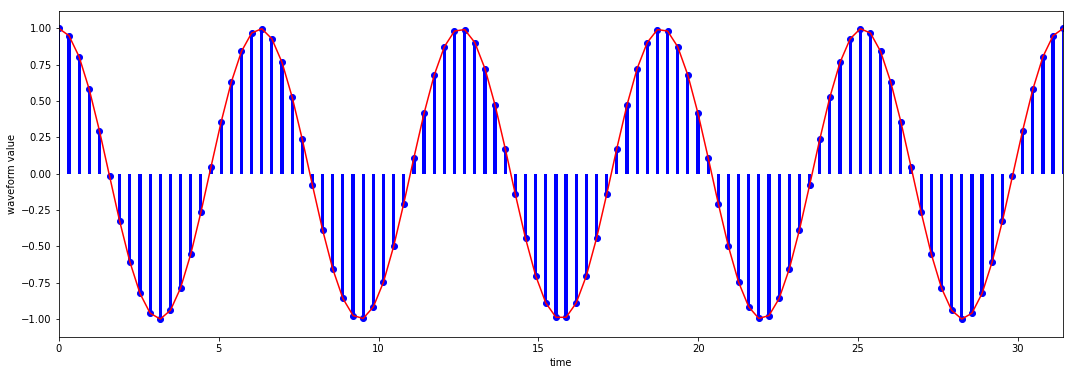

In [17]:
# let's generate a simple wave
x = np.linspace(0, 10*mt.pi, 100)
plt.plot(x, np.cos(x), color='red')
plt.bar(x,np.cos(x), 0.1, color='blue')
plt.scatter(x*1, np.cos(x*1), c='blue', marker='o')
plt.xlim([0, np.max(x)])
plt.xlabel("time")
plt.ylabel("waveform value")
plt.show()

The example above is a bit simplistic. There is a single wave traveling at a fixed frequency. Sounds are made of a large collection of waves of different frequencies and added up together to produce the sound you hear. 

Let's now look at what realistic waveforms look like. 

# Waveform Plotting using librosa

Let's plot the waveform for the audio clip we listened before. In this case, we simply have to plot the `samples` array.

Human voice is a complex combination of different frequencies producing the sound we just heard. Not only does 
the mix of frequencies is slightly different from one person to another, but this mix changes with time to produce the different sounds and words you hear. This complex combination changes quickly over milliseconds. 

A standard approach to analyze sound is to break the audio clip into small chunks in time (let say 10ms) and identify the combination of frequencies that contributed to the sound over that small chunk of time. Repeat that process over a interval of time of 1 second, you will end up with a spectrogram, a 2-D map showing you, for each time chunk, the important frequencies that contributed to the sound in that time interval 

This map provides a unique signature, a fingerprint, of a word uttered by someone. 

In [18]:
# To plot the waveform, I will use the librosa library. This library is particularly useful to anyone who wants to 
# perform audio analysis in Python. 

# You can achieve a similar plotting result using matplotlib.
waveform, sampling_rate = librosa.load(data_dir + example_audio_clip, mono=True, sr=None)

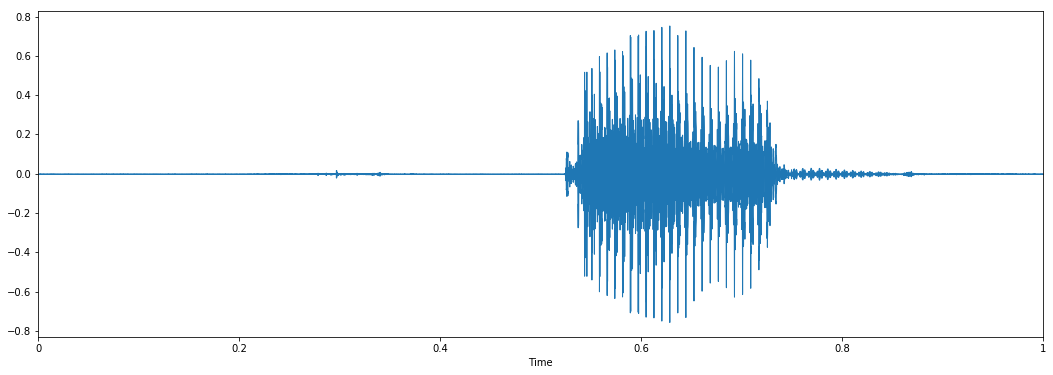

In [19]:
waveplot(waveform, sr=16000)

Let's zoom on the interesting part of the signal 

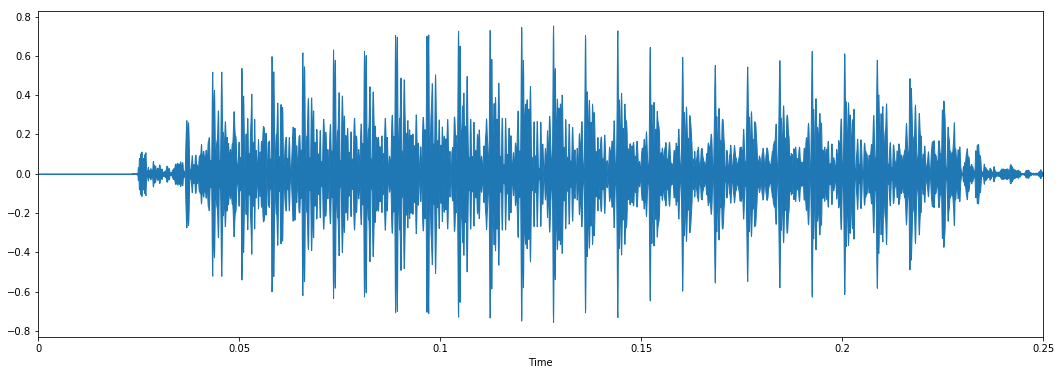

In [20]:
waveplot(waveform[8000:12000], sr=16000)

this is a lot messier than our simple cosine way. In fact, these complicated patterns correspond to a mix of many waves of different frequencies and amplitudes. What we actually measure is the envelope around the sum of these waves. 

Our goal in this notebook will be to cut this clip into small chunks of time and identify which combinations of frequencies contribute to the sound heard in that small chunk of time. This results in a distinctive "fingerprint" of the sound produced. That fingerprint allows us to train models to disentangle "cat" from "dog", for example. This fingerprint is called a spectrogram. We'll discuss spectrograms in more details below. 

# Generate a Synthetic Sound Clip

As you might expect, you can generate synthetic clip and play them back using the `ipython.display` module. Let's take a look: 

In [21]:
# We will generate the standard 440 Hz (A440) pitch standard. 
# This corresponds to musical note A. 
# Try with different musical notes! Middle C has frequency of 261.6 Hz for example. 

# in Hz: 
frequency = 440.0

# sampling rate: 
sr = 16000 
# duration (sec)  
duration = 1.0  
t = np.linspace(0, duration, int(duration * sr), endpoint=False) 
A440 = 0.5 * np.sin(2 * np.pi * frequency * t)                
ipd.Audio(A440, rate=sr)

A perfect A or a Middle C would generate a sinusoidal wave pattern similar to the example above. 

# Feature Extraction: Spectrogram 

We will start looking at simple [spectrograms](https://en.wikipedia.org/wiki/Spectrogram) of spoken words. 

![spectrogram 1](https://user-images.githubusercontent.com/5395649/46774613-2fa21400-ccb8-11e8-9570-cc2441c63ea7.png)

We highly recommend you take a look at the scipy signal processing modules [here](https://docs.scipy.org/doc/scipy/reference/signal.html). Scipy provides a large number of utility functions to process signals and perform spectral analysis.  

As a sidenote : most of human voice is found between 150-3500 Hz. Female voices can go up to about 4 kHz.  

In [22]:
## some utility functions : 

def display_spectrogram(waveform, title="spectrogram", sampling_rate=16000, horizontal_guide=440.0): 
    """Display a spectrogram as a 2D heatmap
    """
    params = {'NFFT':256, 
          'Fs':sampling_rate, 
          'noverlap':128, 
          'cmap' : plt.cm.get_cmap('gnuplot2')}

    spectrum, frequencies, time, _, = plt.specgram(waveform, **params)
    plt.xlabel("time")
    plt.title("{}".format(title))
    plt.ylabel("Frequency (Hz)")
    
    plt.axhline(y=horizontal_guide)
    plt.colorbar()
    plt.show()

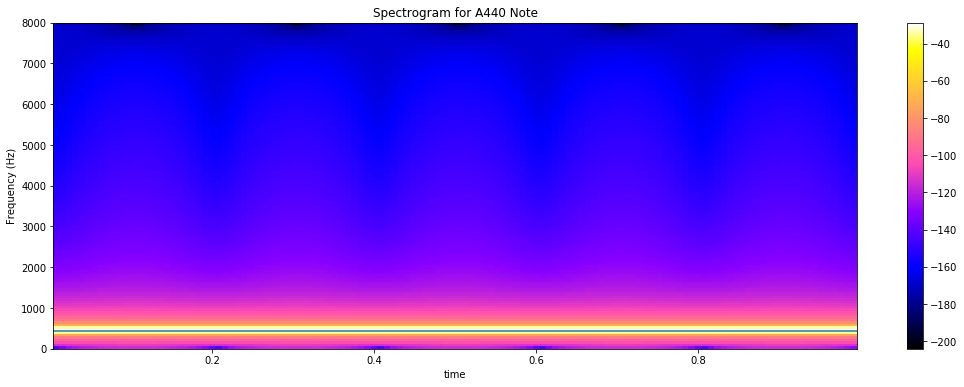

In [23]:
# display spectrogram for the A440 Musical note 
display_spectrogram(A440, title='Spectrogram for A440 Note')

As you may have noticed, the frequency axis does not go up to 16 kHz. In fact, it goes up to only 8 kHz which is half of the sampling frequency of the audio clip. This frequency is known as the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem). In other words, you need to sample a complete cycle with at least two samples to reconstruct that particular frequency.  

This is a pretty simple signal A440. Let's look at a spoken word. 


## A few more examples...  

### Bed

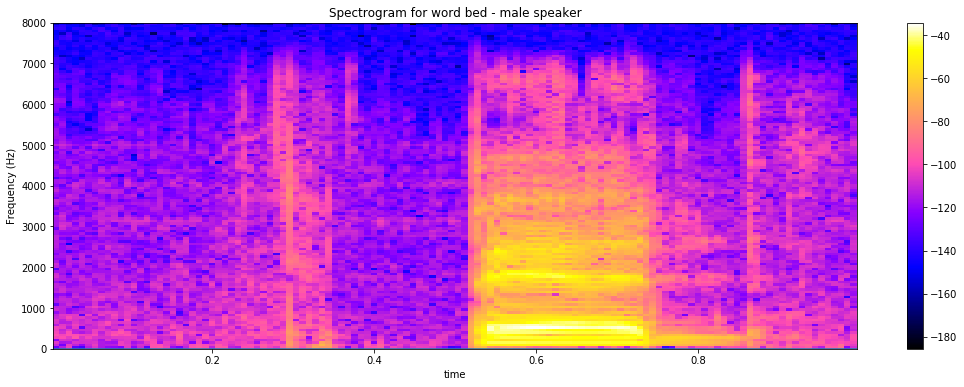

In [24]:
# bed - male speaker 
example_audio_clip = "bed/00176480_nohash_0.wav"
waveform, sampling_rate = librosa.load(data_dir + example_audio_clip, mono=True, sr=None)
display_spectrogram(waveform, title='Spectrogram for word bed - male speaker', horizontal_guide=0)
ipd.Audio(data_dir + example_audio_clip)

### Cat

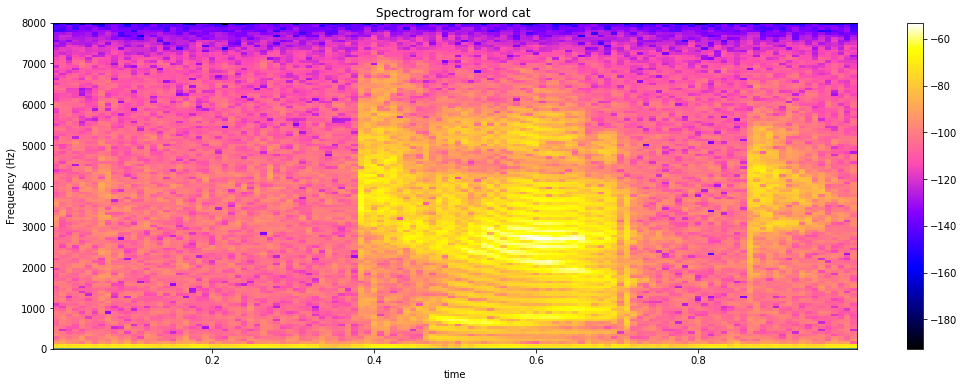

In [25]:
# cat 
example_audio_clip = "cat/004ae714_nohash_0.wav"
waveform, sampling_rate = librosa.load(data_dir + example_audio_clip, mono=True, sr=None)
display_spectrogram(waveform, title='Spectrogram for word cat ', horizontal_guide=0)
ipd.Audio(data_dir + example_audio_clip)

### House

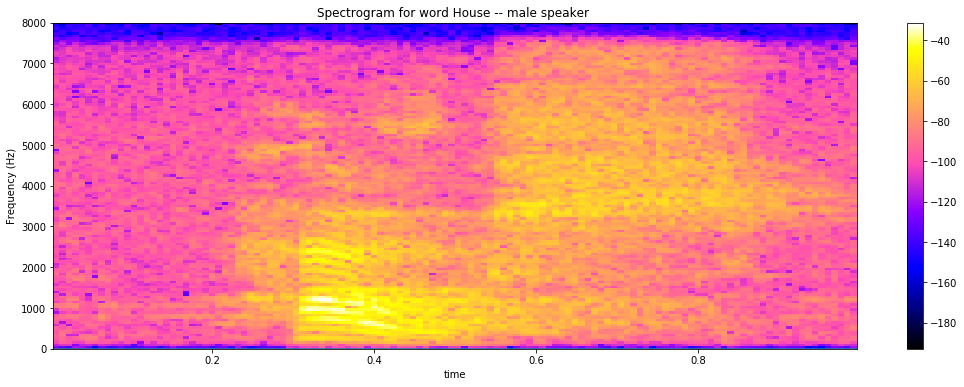

In [27]:
# House  - male speaker 
example_audio_clip = "house/00b01445_nohash_0.wav"
waveform, sampling_rate = librosa.load(data_dir + example_audio_clip, mono=True, sr=None)
display_spectrogram(waveform, title='Spectrogram for word House -- male speaker ', horizontal_guide=0)
ipd.Audio(data_dir + example_audio_clip)

### House -- Female speaker 

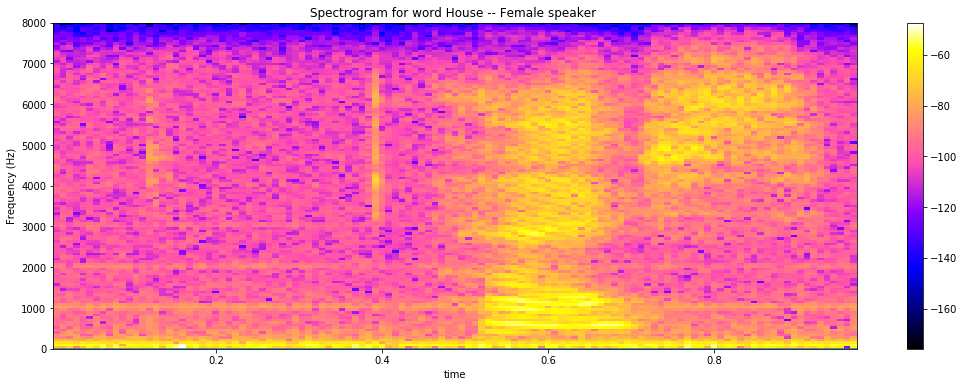

In [28]:
# House - female speaker 
example_audio_clip = "house/014f9f65_nohash_1.wav"
waveform, sampling_rate = librosa.load(data_dir + example_audio_clip, mono=True, sr=None)
display_spectrogram(waveform, title='Spectrogram for word House -- Female speaker ', horizontal_guide=0)
ipd.Audio(data_dir + example_audio_clip)

Did you notice anything between these two examples? First of all, the female speaker example is a lot noisier. 
The spectrogram shows elevated signal throughout the duration of the clip. The frequency range of the female voice is higher than for male voices. You can see peaks (formants) going beyond 3 kHz. You can see that in the signal found in preferentially higher frequencies in the female example. 

Finally, let's take a look at what white noise looks like. 

### White Noise

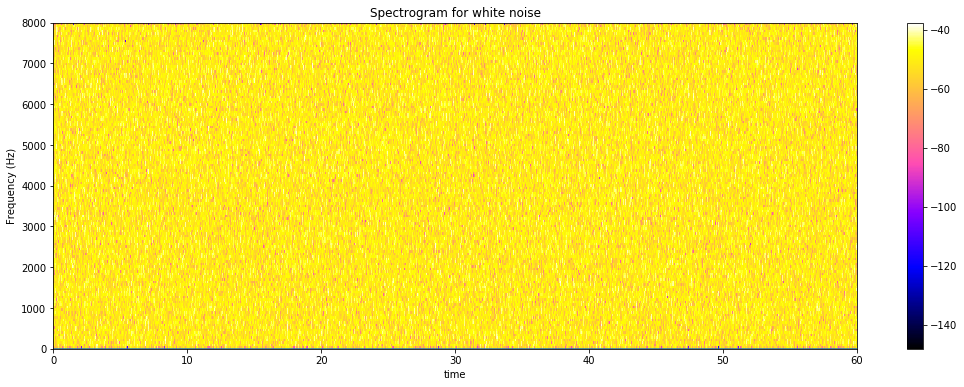

In [29]:
# Background Noise -- white noise 
example_audio_clip = "_background_noise_/white_noise.wav"
waveform, sampling_rate = librosa.load(data_dir + example_audio_clip, mono=True, sr=None)
display_spectrogram(waveform, title='Spectrogram for white noise', horizontal_guide=0)
ipd.Audio(data_dir + example_audio_clip)

# Mel-frequency Cepstral Coefficients 

Although the spectrograms above allow for an easy decomposition of the audio signal into its contributing frequencies, we will be using a more sophisticated mapping before passing these 2-D maps to our CNN model. Instead we will be using Mel-frequency Cepstral Coefficients (MFCC). You can interpret MFCC as a more sophisticated spectrogram. 

What are these MFCCs? Let's start with Mel-frequency first. 

### Mel-frequency 

The [Mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a perceptual scale of pitches that was developed in the early 20th century. Human senses are logarithmic detectors. (As a sidenote, this relates to a discovery that goes back to the work done by Weber & Feichner in the early 19th century and laying out the field of psychophysics. Weber's law relates to human perception and how perceived change relates to actual change. What Weber and Fechner found is that the perceived change in a stimulus is proportional so the initial stimulus itself. In other words if you already feel pain, you'll need a lot more of it to notice any difference while you'll immediately notice a difference if you have no pain at all. The same rule seems to apply to all senses. A difference proportional to the size of the stimulus corresponds to a log scale.

The Mel Scale corresponds to 

$ m = 2595 \log_{10} \bigg(1 + \frac{f}{700} \bigg) $

where $f$ is in Hz. 

### Mel-frequency cepstrum (MFC) 

The Mel-frequency cepstrum is a representation of the power spectrum of a sound over a short period of time. It is derived by doing the following: 
* Take the Fourier Transform of the sound clip over a short time window 
* Map the powers obtained onto the mel scale defined above. Use triangle overlapping filter windows
* Take the logs of the powers at each of the mel frequencies 
* take the discrete cosine transform of the list of mel log powers 

The coefficients (MFCC) are the resulting values. MFCCs are used as features in speech recognition. Each sound is represented by a time series of cepstral vectors. 

### Why using MFCCs? 

MFCCs more closely mimic the regions of the spectrum where the human ear is sensitive. Human ears act like filters and these filters are not spaced uniformly in the frequency space (hence why the Mel-frequencies). There are less of these filters in high frequency regions than in lower ones. 